In [ ]:
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

seed = 15102022
set_seed(seed)

## Read data

In [ ]:
def read_data(file):
    with open(file, 'rb') as fp:
        data = pickle.load(fp)

    images = data.images
    targets = data.target
    target_names = data.target_names

    return images, targets, target_names

images, targets, target_names = read_data('/content/drive/MyDrive/Colab_Notebooks/ml_tasks/data/data.p')


## Data analysis

In [ ]:
def get_stats(targets, target_names):
    labels = np.unique(targets)

    stats = []

    for label in labels:
        num_objects = (targets == label).sum()
        stats.append((label, target_names[label], num_objects))

    return stats

stats = get_stats(targets, target_names)
num_classes = len(stats)

for s in stats:
    print(f'label: {s[0]}, num: {s[2]:3d}, name: {s[1]}')

label: 0, num:  77, name: Ariel Sharon
label: 1, num: 236, name: Colin Powell
label: 2, num: 121, name: Donald Rumsfeld
label: 3, num: 530, name: George W Bush
label: 4, num: 109, name: Gerhard Schroeder
label: 5, num:  71, name: Hugo Chavez
label: 6, num:  60, name: Junichiro Koizumi
label: 7, num: 144, name: Tony Blair


## Split by train and test


In [ ]:
N, H, W = images.shape
features = images.reshape((N, H * W))

X = features
y = targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)


## Calculation of confusion matrix and f1-score

In [ ]:
def calc_confusion_matrix(targets, predictions, num_classes):
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)

    for n, t in enumerate(targets):
        conf_mat[t, predictions[n]] += 1

    return conf_mat

def calc_f1_macro(conf_mat):
    tp = conf_mat.diagonal()

    fp = conf_mat.sum(axis=0) - conf_mat.diagonal()
    fn = conf_mat.sum(axis=1) - conf_mat.diagonal()

    eps = 1e-6

    ppv = tp / (tp + fp + eps)
    tpr = tp / (tp + fn + eps)

    f1 = 2 * tpr * ppv / (tpr + ppv + eps)
    f1_macro = f1.mean()

    return f1_macro * 100

def train(model, X, y, num_classes):
    model.fit(X, y)
    y_pred = model.predict(X)
    conf_mat = calc_confusion_matrix(y, y_pred, num_classes)
    f1_score = calc_f1_macro(conf_mat)

    return model, f1_score

def test(model, X, y, num_classes):
    y_pred = model.predict(X)
    conf_mat = calc_confusion_matrix(y, y_pred, num_classes)
    f1_score = calc_f1_macro(conf_mat)

    return f1_score

## Data normalization

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

## Upsampling method

In [ ]:
def upsample(features, targets, max_objects_in_class=None):
    N = len(targets)
    labels = np.unique(targets)

    data = np.concatenate([targets.reshape((N, 1)), features], axis=1)
    np.random.shuffle(data)

    train_data = []

    for label in labels:
        mask = (data[:, 0] == label)
        class_data = data[mask]

        if max_objects_in_class is not None:
            num = len(class_data)
            num_to_add = max(max_objects_in_class - num, 0)

            if num_to_add == 0:
                class_data = class_data[:max_objects_in_class]
            else:
                indexes = np.arange(num)
                upsample = np.random.choice(indexes, num_to_add)
                class_data = np.vstack((class_data, class_data[upsample]))

        train_data.append(class_data)

    train_data = np.vstack(train_data)

    X_train = train_data[:, 1:]
    y_train = train_data[:, 0].astype(int)

 
    return X_train, y_train


X_train, y_train = upsample(X_train, y_train, max_objects_in_class=530)


## KNN without upsampling

In [ ]:

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn_model,  
                           param_grid = [{'n_neighbors': [1, 2, 4, 8, 16, 32]}],
                           scoring = 'f1_macro',
                           cv = 3,
                           verbose=0)


grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


{'n_neighbors': 1}


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model, f1_train = train(knn_model,  X_train, y_train, num_classes)
f1_test = test(knn_model, X_test, y_test, num_classes)

print(f1_test)

47.92944511247789


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


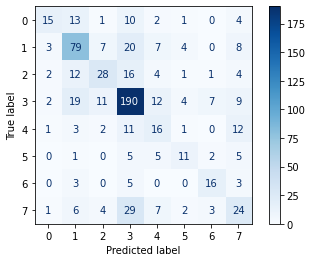

In [ ]:
plot_confusion_matrix(knn_model, X_test, y_test, cmap=plt.cm.Blues)

## KNN with upsampling

In [ ]:

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn_model,  
                           param_grid = [{'n_neighbors': [1, 2, 4, 8, 16, 32]}],
                           scoring = 'f1_macro',
                           cv = 3,
                           verbose=0)


grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'n_neighbors': 1}


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model, f1_train = train(knn_model,  X_train, y_train, num_classes)
f1_test = test(knn_model, X_test, y_test, num_classes)

print(f1_test)

48.08861509940547


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


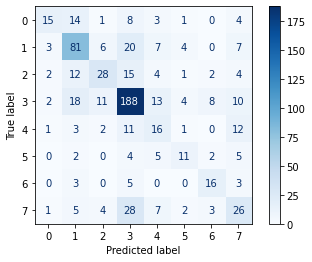

In [ ]:
plot_confusion_matrix(knn_model, X_test, y_test, cmap=plt.cm.Blues)

## SVM without upsampling


In [ ]:
svm_model = SVC()

grid_search = GridSearchCV(estimator = svm_model,  
                           param_grid = [{'kernel': ['rbf', 'poly', 'linear'],
                                          'C': [1, 2, 3, 4]}],
                           scoring = 'f1_macro',
                           cv = 3,
                           verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'C': 1, 'kernel': 'linear'}


In [ ]:
svm_model = SVC(kernel='linear', C=1)

svm_model, f1_train = train(svm_model,  X_train, y_train, num_classes)
f1_test = test(svm_model, X_test, y_test, num_classes)

print(f1_test)

79.72739975331251


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


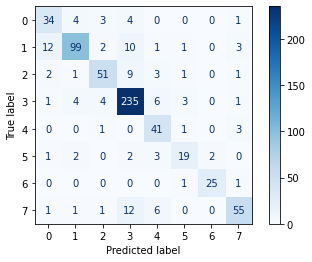

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test, cmap=plt.cm.Blues)

## SVM with upsampling

In [ ]:
svm_model = SVC()

grid_search = GridSearchCV(estimator = svm_model,  
                           param_grid = [{'kernel': ['rbf', 'poly', 'linear'],
                                          'C': [1, 2, 3, 4]}],
                           scoring = 'f1_macro',
                           cv = 3,
                           verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'C': 4, 'kernel': 'rbf'}


In [ ]:
svm_model = SVC(kernel='rbf', C=4)

svm_model, f1_train = train(svm_model,  X_train, y_train, num_classes)
f1_test = test(svm_model, X_test, y_test, num_classes)

print(f1_test)

72.7642873340673


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


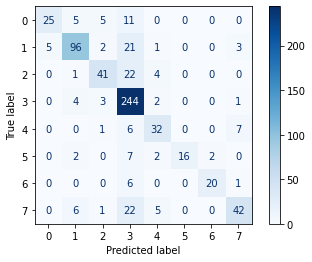

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test, cmap=plt.cm.Blues)